# Normalized Radiance Retrieval and Visualization

Here we show how to access an HDF file and plot the normalized polarized and unpolarized radiances using functions that live in our nasa_polotting_scripts.py module

In [1]:
import pandas as pd
import h5py
from pyhdf.SD import SD, SDC
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
# os.chdir('/Users/pcause/Downloads/CALTRACK-333m_2010_03_01')
# os.getcwd()

In [2]:
rad_list = [
    'Normalized_Radiance_443NP',
    'Normalized_Radiance_490P',
    'Normalized_Radiance_1020NP',
    'Normalized_Radiance_565NP',
    'Normalized_Radiance_670P',
    'Normalized_Radiance_763NP',
    'Normalized_Radiance_765NP',
    'Normalized_Radiance_865P',
    'Normalized_Radiance_910NP'
]
q_fields = [
    'Q_Stokes_490P',
    'Q_Stokes_670P',
    'Q_Stokes_865P'
]
u_fields  = [
    'U_Stokes_490P',
    'U_Stokes_670P',
    'U_Stokes_865P'
]

In [3]:
filedir = '/Users/pcause/Downloads/'
file = filedir + 'CALTRACK-333m_PAR-L1B_V1-00_2009-07-04T15-09-32ZD.hdf'

# file = 'C:\\Users\\whetz\\Documents\\UVA MSDS\\NASA\\hdf_files\\CALTRACK-333m_2010_03_01\\2010-03-02\\CALTRACK-333m_PAR-L1B_V1-00_2010-03-02T17-20-38ZD.hdf'
hdf = SD(file, SDC.READ)

In [8]:
def get_tracked_parasol(file, step = 20, north_tracks=2, south_tracks=2):

    hdf = SD(file, SDC.READ)
    lats = (list(hdf.select('Latitude').get()))
    lons = (list(hdf.select('Longitude').get()))

    lat = 34.540852
    lon = -68.379303

    buffer = 0.001
    lat1 = lat - buffer
    lat2 = lat + buffer
    lon1 = lon - buffer
    lon2 = lon + buffer

    df_coord = pd.DataFrame({'lat':lats,'lon':lons})
    print(df_coord)
    index = df_coord.query(F"lat > {lat1} & lat < {lat2} & lon > {lon1} & lon < {lon2}").index[0]

    master_df = pd.DataFrame()

    # Loop through each track based on initial index and specified step
    for i in range(-1*(south_tracks),north_tracks+1):
        ind = index + step*i
        
        # Get the coordinates & time
        lat = pd.DataFrame(hdf.select('Latitude').get()).loc[ind][0]
        lon = pd.DataFrame(hdf.select('Longitude').get()).loc[ind][0]
        time = pd.DataFrame(hdf.select('Time').get()).loc[ind][0]
                
        # Loop through each radiance 
        rad_df = pd.DataFrame()
        for rad in rad_list:
            temp = pd.DataFrame(hdf.select(rad).get()).loc[ind]
            transform = [round(i*(10**(-4)),5) if i > -1000 else i for i in list(temp)]
            
            df_temp = (pd.DataFrame(transform).transpose())
            df_temp['Wavelength'] = (rad).replace('Normalized_Radiance_','')
            rad_df = pd.concat([rad_df,df_temp])

        
        # Rest index and rename the columns
        rad_df = rad_df.reset_index(drop=True)
        rad_cols = ([i for i in range(16)])
        rad_cols.append('wavelength')
        rad_df.columns = rad_cols

#         # Get q data and add to the dataframe
#         q_df = pd.DataFrame()
#         for q in q_fields:
            
#             temp = pd.DataFrame(hdf.select(q).get()).loc[ind]
#             transform = [round(i*(10**(-4)),5) if i > -1000 else i for i in list(temp)]
            
#             df_temp = pd.DataFrame(transform).transpose()
            
#             df_temp['wavelength'] = q.replace('Q_Stokes_','')
#             q_df = pd.concat([q_df, df_temp])

#         qcols = [i for i in range(16)]
#         qcols.append('wavelength')
#         q_df.columns = qcols

#         # Get u data and add to the dataframe
#         u_df = pd.DataFrame()
#         for u in u_fields:
            
#             temp = pd.DataFrame(hdf.select(q).get()).loc[ind]
#             transform = [round(i*(10**(-4)),5) if i > -1000 else i for i in list(temp)]
            
#             df_temp = pd.DataFrame(transform).transpose()
#             df_temp['wavelength'] = u.replace('U_Stokes_','')
#             u_df = pd.concat([u_df, df_temp])
            
#         ucols = [i for i in range(16)]
#         ucols.append('wavelength')
#         u_df.columns = ucols
        
#         # Melt the matrices
        rad_melt = rad_df.melt(id_vars='wavelength',value_vars=[i for i in range(16)], var_name='angle', value_name='norm_rad')
        q_melt = q_df.melt(id_vars='wavelength',value_vars=[i for i in range(16)], var_name='angle', value_name='q')
        u_melt = u_df.melt(id_vars='wavelength',value_vars=[i for i in range(16)], var_name='angle', value_name='u')
        
        # join each matrix
        df_merge = pd.merge(left=rad_melt, right=q_melt, how='left',on=['wavelength', 'angle'])
        df_merge = pd.merge(left=df_merge, right=u_melt, how='left',on=['wavelength', 'angle'])
        
        # replace missing data with np.nan
        df_merge.replace(-32768, np.NaN)

        # Calclate Degree of linear polarization
        df_merge['dolp'] = round(np.sqrt(df_merge.q**2 + df_merge.u**2)/df_merge.norm_rad,3)
        
        # Add traack column
        df_merge['track'] = i

        # Filter for non-missing values
        df_merge = df_merge.query("norm_rad > -1000")
        
        # Add in coordinate values and time values
        df_merge['lat'] = [lat for i in range(len(df_merge))]
        df_merge['lon'] = [lon for i in range(len(df_merge))]
        df_merge['coord'] = [str(round(df_merge.loc[i].lat,5)) + ', ' + str(round(df_merge.loc[i].lon,5))  for i in range(len(df_merge))]
        df_merge['time'] = [time for i in range(len(df_merge))]
                                                                   
        # Add to master df and go to next track
        master_df = pd.concat([master_df, df_merge]).reset_index(drop=True)
        
    return master_df

df = get_tracked_parasol(file)
df

             lat         lon
0     -65.971008   -1.537541
1     -65.968216   -1.540328
2     -65.965424   -1.543115
3     -65.962631   -1.545901
4     -65.959831   -1.548686
...          ...         ...
63280  55.923050  158.878876
63281  55.920143  158.877319
63282  55.917240  158.875763
63283  55.914333  158.874207
63284  55.911427  158.872635

[63285 rows x 2 columns]


""


In [56]:
def plot_tracked_parasol(master_df, np=True):
    non_pols = [
        '443NP',
        '1020NP',
        '565NP',
        '763NP',
        '765NP',
        '910NP'
    ]

    pols = [
        '490P',
        '670P',
        '865P'
    ]
    df_np = master_df[master_df.wavelength.isin(non_pols)]
    df_p = master_df[master_df.wavelength.isin(pols)]

    if np:
        g = sns.FacetGrid(df_np, col="coord", height=10, aspect=.75)
        g.map_dataframe(sns.lineplot, x="angle", y="norm_rad", hue='wavelength')
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(('Normalized Radiance for Non-Polarized Wavelenghts by Viewing Angle').upper())
        g.add_legend()
    else:
        g = sns.FacetGrid(df_p, col="coord", height=10, aspect=.75)
        g.map_dataframe(sns.lineplot, x="angle", y="dolp", hue='wavelength')
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(('Degree of Linear Polarization by Viewing Angle').upper())
        g.add_legend()

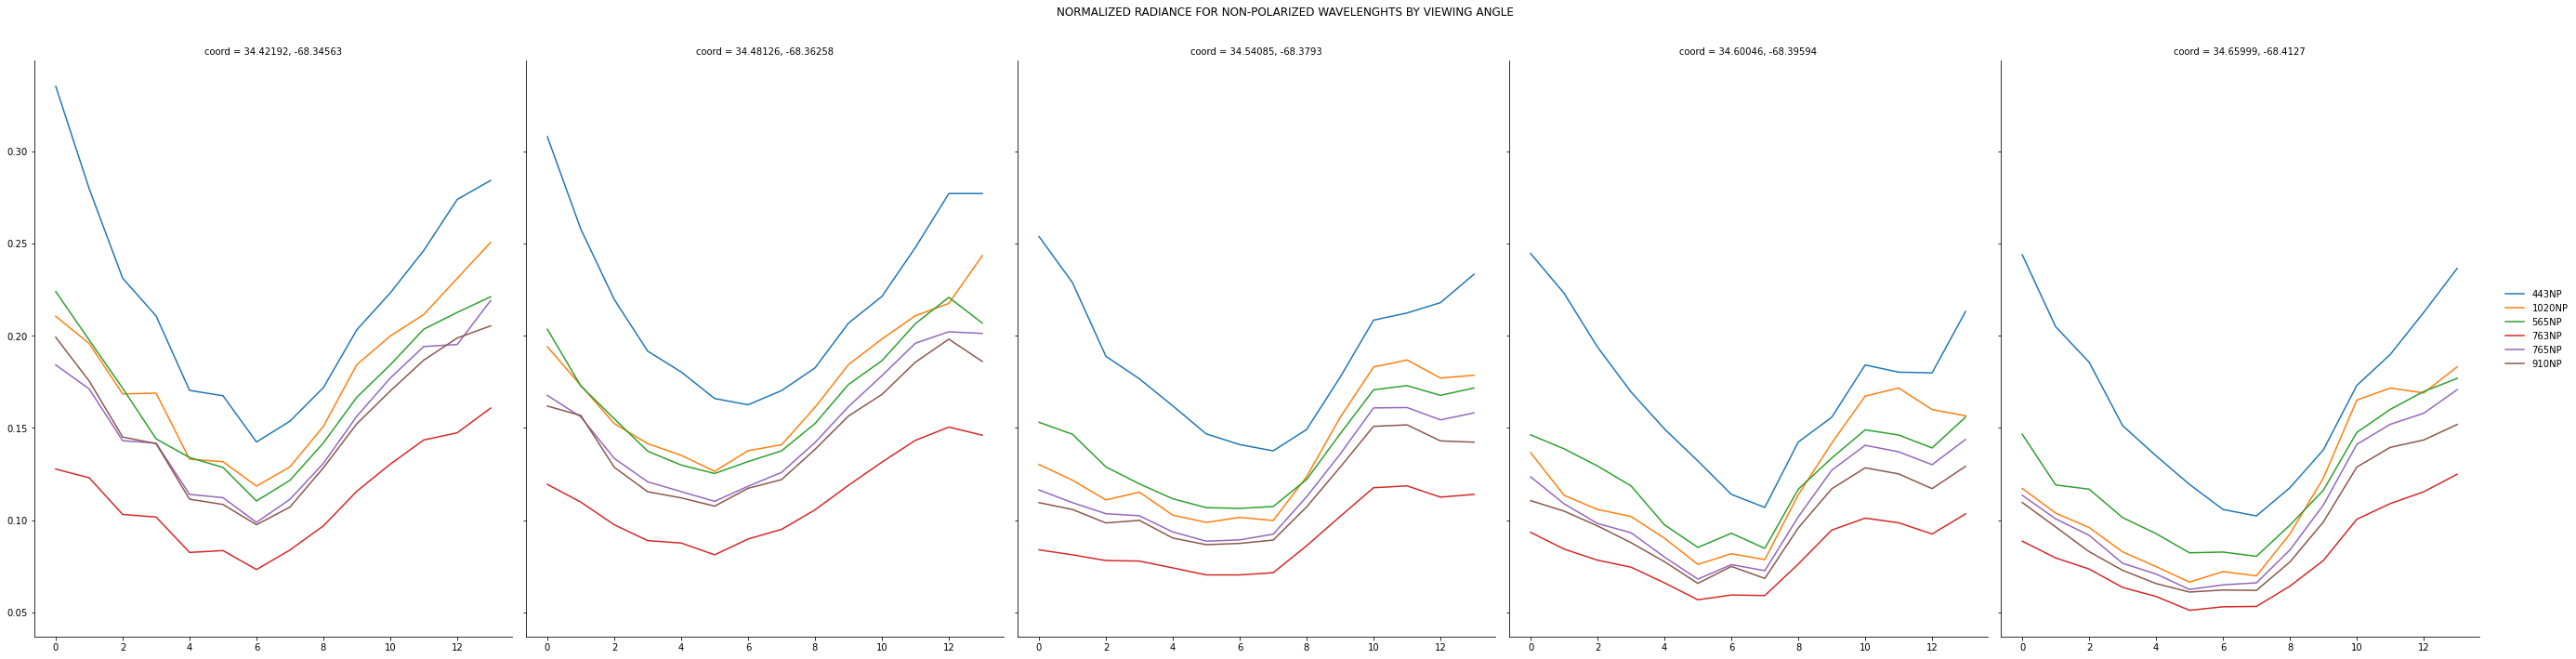

In [57]:
plot_tracked_parasol(df)

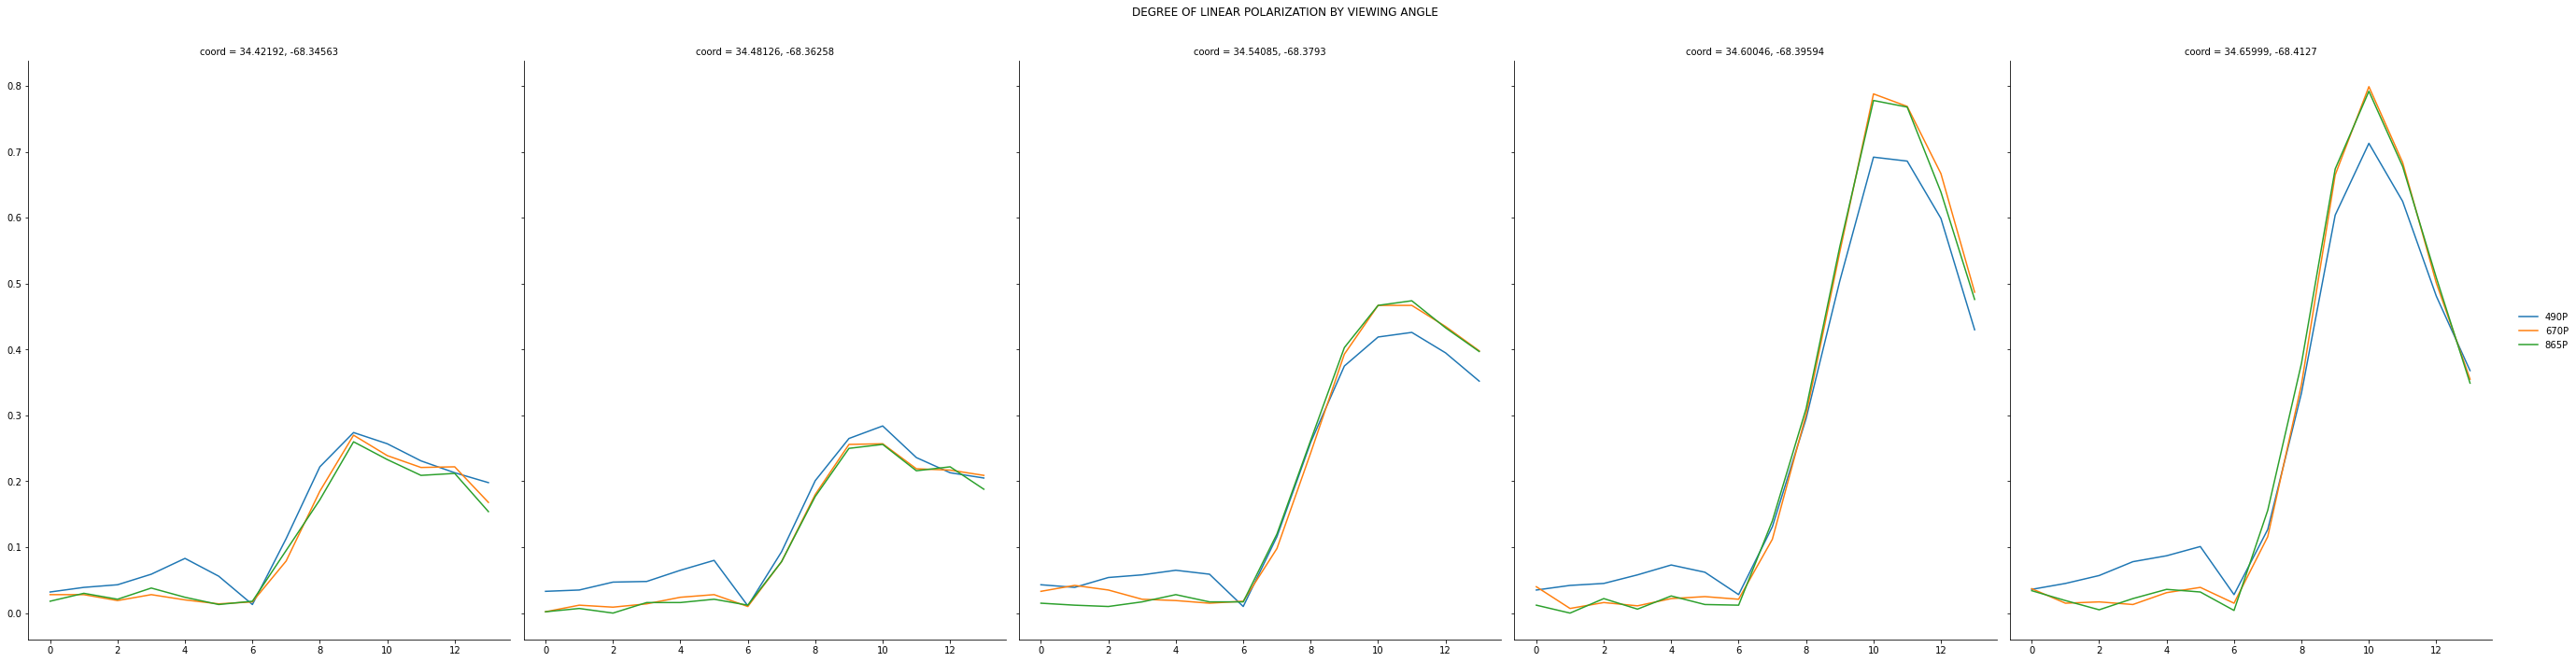

In [58]:
plot_tracked_parasol(df, np=False)

In [8]:
df_temp = df.query("wavelength=='443NP' & angle == 0")
lats = list(df_temp.lat)
lons = list(df_temp.lon)
tracks = list(df_temp.track)
df_coord = pd.DataFrame({'lat':lats,'lon':lons,'track':tracks})
df_coord

,lat,lon,track
0,34.421921,-68.345634,-2
1,34.481258,-68.362579,-1
2,34.540852,-68.379303,0
3,34.600460,-68.395943,1
4,34.659988,-68.412704,2


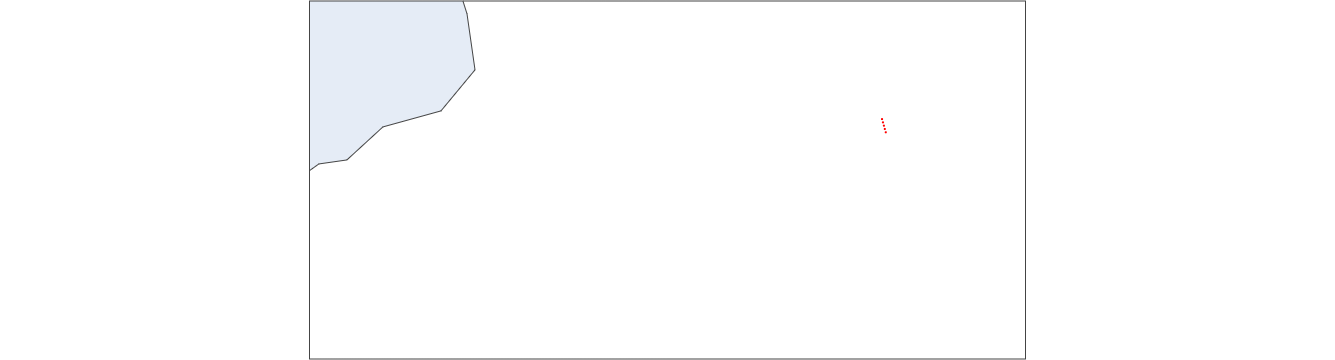

In [28]:
import plotly.graph_objects as go
import pandas as pd

fig = go.Figure()

df_temp = df.query("wavelength=='443NP' & angle == 0")
lats = list(df_temp.lat)
lons = list(df_temp.lon)
tracks = list(df_temp.track)
df_coord = pd.DataFrame({'lat':lats,'lon':lons,'track':tracks})
df_coord['coord'] = [str(round(df_coord.loc[i].lat,5)) + ', ' + str(round(df_coord.loc[i].lon,5))  for i in range(len(df_coord))]
df_coord

fig.add_trace(go.Scattergeo(
    lon = df_coord['lon'],
    lat = df_coord['lat'],
    hoverinfo = 'text',
    text = df_coord['coord'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.update_layout(margin=dict(l=1, r=1, t=1, b=1))

### Find all files in the corpus that have coordinates in the AOI

In [10]:
def get_all_files(area1, area2):
    lat_max = max([area1[0],area2[0]])
    lat_min = min([area1[0],area2[0]])

    lon_max = max([area1[1],area2[1]])
    lon_min = min([area1[1],area2[1]])
    query = F"lat < {lat_max} & lat > {lat_min} & lon < {lon_max} & lon > {lon_min}"
    
    folders = []
    files = []

    os.chdir('C:\\Users\\whetz\\Documents\\UVA MSDS\\NASA\\hdf_files\\CALTRACK-333m_2010_03_01')
    for folder in os.listdir():
        if folder[0] != '2':
            continue
        directory = 'C:\\Users\\whetz\\Documents\\UVA MSDS\\NASA\\hdf_files\\CALTRACK-333m_2010_03_01\\' + folder
        os.chdir(directory)
        count = 1
    #     print("Count:", end='')
        for file in os.listdir():
            if file[0] != 'C':
                continue
    #         print(count, end=', ')
            hdf = SD(file, SDC.READ)

            lats = pd.Series(hdf.select('Latitude').get())
            lons = pd.Series(hdf.select('Longitude').get())

            lat_df = pd.DataFrame(lats)
            lon_df = pd.DataFrame(lons)

            df_rad = pd.DataFrame(hdf.select('Normalized_Radiance_670P').get())
            df = pd.concat([lat_df, lon_df, df_rad], axis=1)

            cols = ['lat','lon']
            for i in range(0,16):
                cols.append(i)
            df.columns=cols

#             query = "lat < " + str()
            
            if (len(df.query(query))) > 0:
    #             print("HERE!")
                folders.append(folder)
                files.append(file)
                print(file)

            count += 1

    folder_dict = {}
    count = 0
    for i in folders:
        folder_dict[i] = files[count]
        count += 1
    return folder_dict